In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
import re
import os
import pickle
from sklearn.preprocessing import StandardScaler
%matplotlib inline


# Let's use AMZN (Amazon), AAPL (Apple), GOOG (Google), MSFT (Microsoft)
def get_data(choices):
    # returns a T x 3 list of stock prices
    # each row is a different stock
    # 0 = AMZN
    # 1 = APPL
    # 2 = GOOG
    # 3 = MSFT 
    choice_map = {1: 'amazon',
                  2: 'apple',
                  3: 'google',
                  4: 'microsoft',
                  5: 'All'}
    df = pd.read_csv('amzn_aapl_goog_msft.csv')
    stocks = {}
    if choices[0] == 5:
        return df.values
    for ch in choices:
        if ch:
            stocks[choice_map[ch]] = df[choice_map[ch]]
    df1 = pd.DataFrame(stocks)
    return df1.values


def get_scaler(env):
  # return scikit-learn scaler object to scale the states
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler


def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        

class LinearModel:
    """ A linear regression model """
    
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        # momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []

    def predict(self, X):
        # make sure X is N x D
        assert(len(X.shape) == 2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.95):
        # make sure X is N x D
        assert(len(X.shape) == 2)

        # the loss values are 2-D
        # normally we would divide by N only
        # but now we divide by N x K
        num_values = np.prod(Y.shape)

        # do one step of gradient descent
        # we multiply by 2 to get the exact gradient
        # (not adjusting the learning rate)
        # i.e. d/dx (x^2) --> 2x
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

        # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

        # update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)

    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)
        

class MultiStockEnv:
    """
    A 3-stock trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
    """
    def __init__(self, data, initial_investment=20000):
        # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like for 3 companies:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = buy
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.cur_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {'cur_val': cur_val}

        # conform to the Gym API
        return self._get_obs(), reward, done, info


    def _get_obs(self):
    #
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs



    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = [] # stores index of stocks we want to sell
        buy_index = [] # stores index of stocks we want to buy
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
          # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
          for i in sell_index:
            self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
            self.stock_owned[i] = 0
        if buy_index:
          # NOTE: when buying, we will loop through each stock we want to buy,
          #       and buy one share at a time until we run out of cash
                can_buy = True
                while can_buy:
                    for i in buy_index:
                        if self.cash_in_hand > self.stock_price[i]:
                            self.stock_owned[i] += 1 # buy one share
                            self.cash_in_hand -= self.stock_price[i]
                        else:
                            can_buy = False
                            
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:  # exploring by taking a random action
              return np.random.choice(self.action_size)
        act_values = self.model.predict(state) # exploiting by taking the action which is predicted 
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)

                            
def play_one_episode(agent, env, is_train, scaler):
    # note: after transforming states are already 1xD
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state) # get action
        next_state, reward, done, info = env.step(action) # get the next state, reward etc 
        next_state = scaler.transform([next_state])
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        state = next_state

    return info['cur_val']


In [5]:
def test_train():
    threshold_investment = 10000 # initial investment should be greater than this
    investment = 20000  # initial investment

    # hyper parameters
    episodes = 20 # number of times the model is to be trained
    l_r = 0.01  # learninng rate
    mom = 0.9  # momentum of stochastic gradient descent
    batch = 32 # batch size
    epsilon = 1 # exploration rate
    epsilon_decay = 0.995 # decay of exploration
    epsilon_min = 0.01 # threshold of exploration rate
    gamma = 0.95  # discount factor

    print('Enter your choice of companies')
    print('1 - Amazon')
    print('2 - Apple')
    print('3 - Google')
    print('4 - Microsoft')
    print('5 - All')
    print('0 - exit')

    # taking inout from the user 
    choices = [] # to store list of selected companies
    exit = False
    while not exit:
        print('Enter your company')
        choice = int(input())
        if choice not in range(6):
            print('Please enter valid company')
        if choice == 5 or choice == 0:
            exit = True
        else:
            choices.append(choice)
#     print('Enter your initial investment')
#     while True:
#         investment = int(input())
#         if investment < threshold_investment:
#             print('Enter investment greater than Rupees 10000')
#         else:
#             break

    # config
    models_folder = 'linear_rl_trader_models'
    rewards_folder = 'linear_rl_trader_rewards'
    num_episodes = episodes
    batch_size = batch
    initial_investment = investment

    make_dir(models_folder)
    make_dir(rewards_folder)

    data = get_data(choices)
    n_timesteps, n_stocks = data.shape

    n_train = 1008 # 50% training data and 50% testing data

    train_data = data[:n_train]
    test_data = data[n_train:]

    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    # store the final value of the portfolio (end of episode)
    train_portfolio_value = []
    
    print("-------------------In Training Phase----------------------------------------------------")
    # repeat the experiemnt num_episodes times
    print('please wait we are training on the your choice of companies')
    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, 'train',scaler)
        dt = datetime.now() - t0
#         print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        train_portfolio_value.append(val) # append episode end portfolio value
    
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # plot losses
#     print('The loss in training phase')
#     plt.plot(agent.model.losses)
#     plt.show()
    
    average = sum(train_portfolio_value)/len(train_portfolio_value)
    avg_return = average/initial_investment
    min_return = min(train_portfolio_value)/initial_investment
    max_return = max(train_portfolio_value)/initial_investment
    print(f"After training for {num_episodes} episodes and an intial investment of {initial_investment}:")
    print(f"Average total return amount: {average:.2f}")
    print(f"Average returns on total investment: {avg_return:.2f}")
    print(f"Minimum returns on total investment: {min_return:.2f}")
    print(f"Maximum returns on total investment: {max_return:.2f}")
    np.save(f'{rewards_folder}/{"train"}.npy', train_portfolio_value)
    
    print("-----------------In Testing Phase-------------------------------------------------------")
    print('please wait we are testing on the your choice of companies')
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
              scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01 # exploration in testing phase

    # load trained weights
    agent.load(f'{models_folder}/linear.npz')
    
    test_portfolio_value = []
    # repeat the experiemnt num_episodes times
    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, 'test',scaler)
        dt = datetime.now() - t0
#         print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        test_portfolio_value.append(val) # append episode end portfolio value
        

    average = sum(test_portfolio_value)/len(test_portfolio_value)
    avg_return = average/initial_investment
    min_return = min(test_portfolio_value)/initial_investment
    max_return = max(test_portfolio_value)/initial_investment
    print(f"After testing for {num_episodes} episodes and an intial investment of {initial_investment}:")
    print(f"Average total return amount: {average:.2f}")
    print(f"Average returns on total investment: {avg_return:.2f}")
    print(f"Minimum returns on total investment: {min_return:.2f}")
    print(f"Maximum returns on total investment: {max_return:.2f}")
    np.save(f'{rewards_folder}/{"test"}.npy', test_portfolio_value)
    print()
    print()
    print('Returns in training phase')
    plt.plot(train_portfolio_value)
    plt.show()
    print()
    print('Returns in testing phase')
    plt.plot(test_portfolio_value)
    plt.show()
    

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 27396.96
Average returns on total investment: 1.37
Minimum returns on total investment: 0.94
Maximum returns on total investment: 2.86
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 20120.14
Average returns on total investment: 1.01
Minimum returns on total investment: 0.99
Maximum returns on total investment: 1.04


Returns in training phase


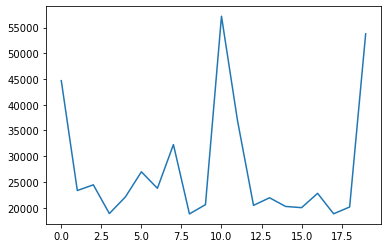


Returns in testing phase


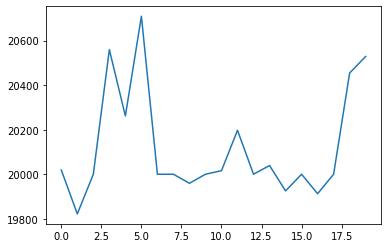

In [11]:
#Amazon
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
2
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 22758.31
Average returns on total investment: 1.14
Minimum returns on total investment: 0.90
Maximum returns on total investment: 2.18
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 19976.67
Average returns on total investment: 1.00
Minimum returns on total investment: 0.96
Maximum returns on total investment: 1.06


Returns in training phase


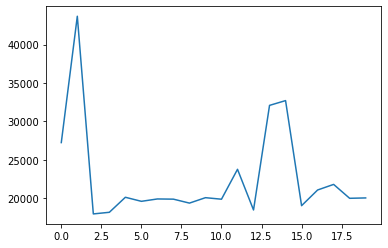


Returns in testing phase


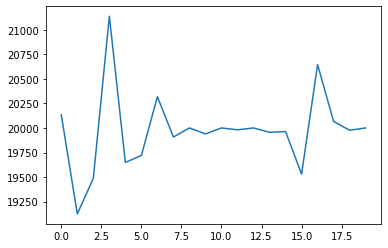

In [17]:
#Apple
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
3
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 23279.31
Average returns on total investment: 1.16
Minimum returns on total investment: 0.82
Maximum returns on total investment: 2.12
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 21576.10
Average returns on total investment: 1.08
Minimum returns on total investment: 0.90
Maximum returns on total investment: 1.41


Returns in training phase


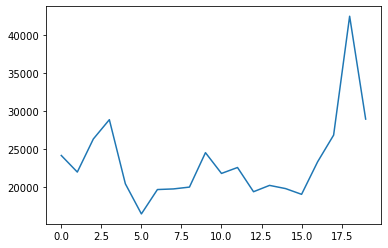


Returns in testing phase


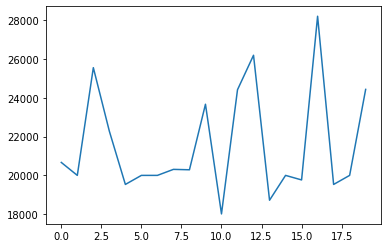

In [18]:
#Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 22996.71
Average returns on total investment: 1.15
Minimum returns on total investment: 0.69
Maximum returns on total investment: 2.27
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 20105.14
Average returns on total investment: 1.01
Minimum returns on total investment: 0.96
Maximum returns on total investment: 1.09


Returns in training phase


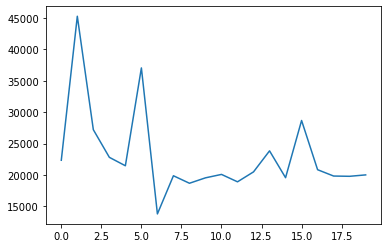


Returns in testing phase


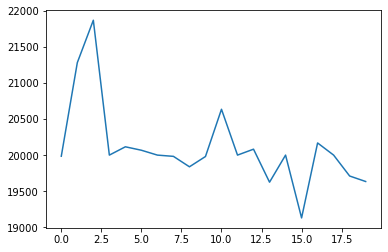

In [21]:
#Microsoft
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
2
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 41345.62
Average returns on total investment: 2.07
Minimum returns on total investment: 1.53
Maximum returns on total investment: 3.46
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 39802.16
Average returns on total investment: 1.99
Minimum returns on total investment: 1.73
Maximum returns on total investment: 2.27


Returns in training phase


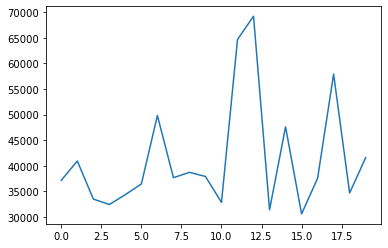


Returns in testing phase


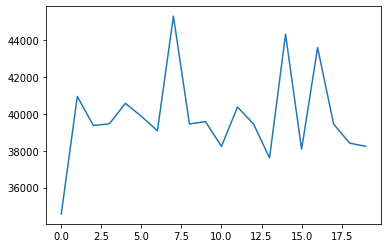

In [25]:
#Amazon-Apple
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
3
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 37283.28
Average returns on total investment: 1.86
Minimum returns on total investment: 1.23
Maximum returns on total investment: 3.10
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 28022.54
Average returns on total investment: 1.40
Minimum returns on total investment: 1.16
Maximum returns on total investment: 1.93


Returns in training phase


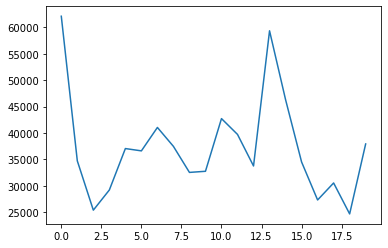


Returns in testing phase


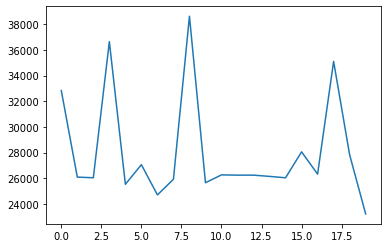

In [29]:
#Amazon-Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 44663.68
Average returns on total investment: 2.23
Minimum returns on total investment: 1.07
Maximum returns on total investment: 3.62
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 33265.66
Average returns on total investment: 1.66
Minimum returns on total investment: 1.34
Maximum returns on total investment: 1.89


Returns in training phase


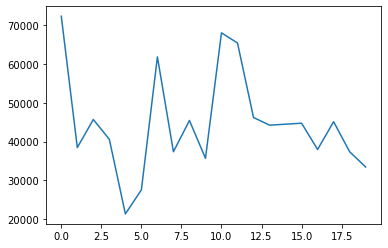


Returns in testing phase


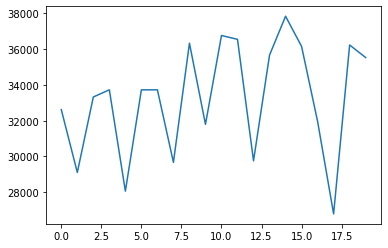

In [30]:
#Amazon-Micrsoft
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
2
Enter your company
3
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 28952.13
Average returns on total investment: 1.45
Minimum returns on total investment: 0.79
Maximum returns on total investment: 2.31
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 25294.07
Average returns on total investment: 1.26
Minimum returns on total investment: 1.02
Maximum returns on total investment: 1.35


Returns in training phase


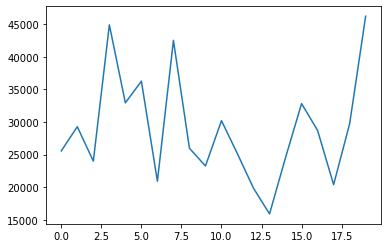


Returns in testing phase


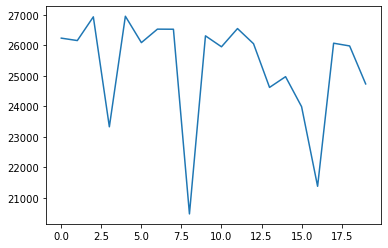

In [38]:
#Apple Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
2
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 33703.08
Average returns on total investment: 1.69
Minimum returns on total investment: 1.07
Maximum returns on total investment: 2.92
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 30893.81
Average returns on total investment: 1.54
Minimum returns on total investment: 1.34
Maximum returns on total investment: 2.03


Returns in training phase


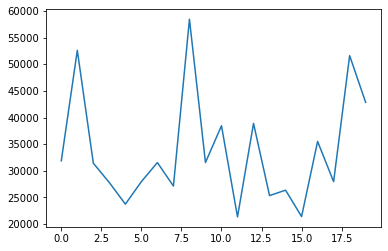


Returns in testing phase


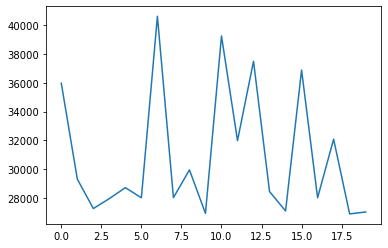

In [39]:
#Apple Microsoft
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
3
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 38074.57
Average returns on total investment: 1.90
Minimum returns on total investment: 1.16
Maximum returns on total investment: 2.78
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 31556.58
Average returns on total investment: 1.58
Minimum returns on total investment: 1.29
Maximum returns on total investment: 1.68


Returns in training phase


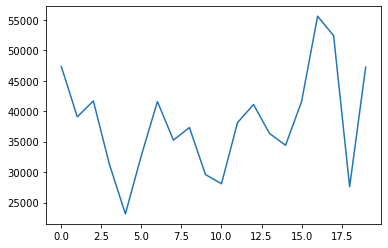


Returns in testing phase


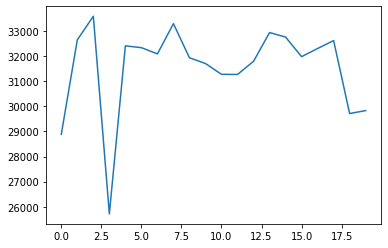

In [43]:
#Google Microsoft
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
2
Enter your company
3
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 44354.61
Average returns on total investment: 2.22
Minimum returns on total investment: 1.40
Maximum returns on total investment: 2.67
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 31493.63
Average returns on total investment: 1.57
Minimum returns on total investment: 1.09
Maximum returns on total investment: 1.89


Returns in training phase


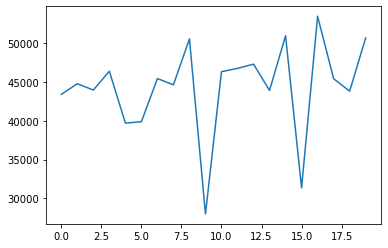


Returns in testing phase


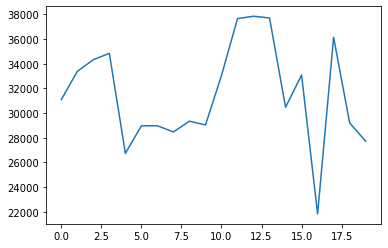

In [44]:
#Amazon Apple Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
2
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 56931.59
Average returns on total investment: 2.85
Minimum returns on total investment: 1.22
Maximum returns on total investment: 5.35
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 36227.78
Average returns on total investment: 1.81
Minimum returns on total investment: 1.68
Maximum returns on total investment: 1.89


Returns in training phase


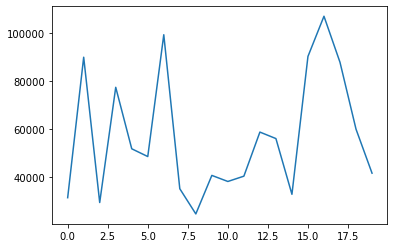


Returns in testing phase


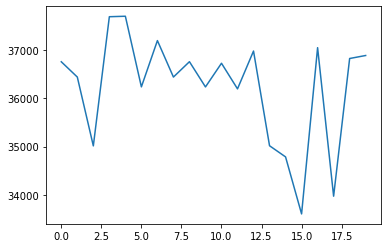

In [45]:
#Apple Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
3
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 53113.78
Average returns on total investment: 2.66
Minimum returns on total investment: 1.45
Maximum returns on total investment: 4.13
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 30920.51
Average returns on total investment: 1.55
Minimum returns on total investment: 1.23
Maximum returns on total investment: 1.81


Returns in training phase


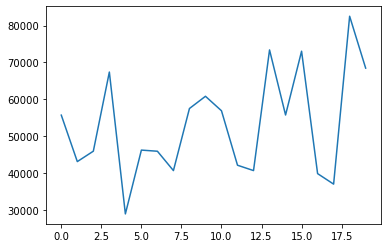


Returns in testing phase


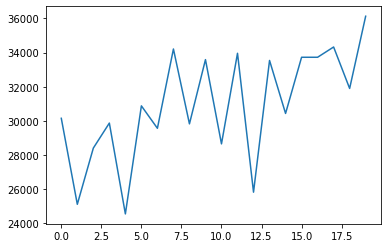

In [46]:
#Apple Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
2
Enter your company
3
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 40553.47
Average returns on total investment: 2.03
Minimum returns on total investment: 0.69
Maximum returns on total investment: 2.91
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 32422.42
Average returns on total investment: 1.62
Minimum returns on total investment: 1.36
Maximum returns on total investment: 2.06


Returns in training phase


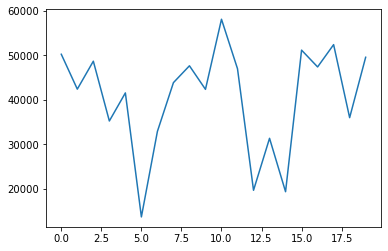


Returns in testing phase


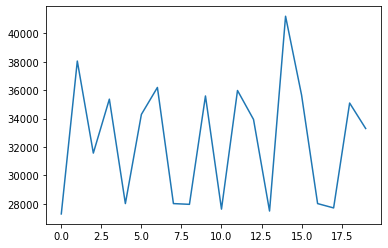

In [47]:
#Apple Google
test_train()

Enter your choice of companies
1 - Amazon
2 - Apple
3 - Google
4 - Microsoft
5 - All
0 - exit
Enter your company
1
Enter your company
2
Enter your company
3
Enter your company
4
Enter your company
0
-------------------In Training Phase----------------------------------------------------
please wait we are training on the your choice of companies
After training for 20 episodes and an intial investment of 20000:
Average total return amount: 55192.54
Average returns on total investment: 2.76
Minimum returns on total investment: 1.95
Maximum returns on total investment: 4.66
-----------------In Testing Phase-------------------------------------------------------
please wait we are testing on the your choice of companies
After testing for 20 episodes and an intial investment of 20000:
Average total return amount: 28684.14
Average returns on total investment: 1.43
Minimum returns on total investment: 1.34
Maximum returns on total investment: 1.57


Returns in training phase


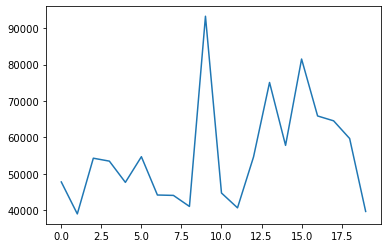


Returns in testing phase


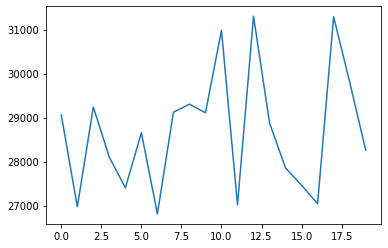

In [51]:
#Apple Google
test_train()

In [52]:
pwd

'/Users/saqpasha/Desktop/Final Capstone Project'